In [1]:
# Importing needed modules for handling tabular data & accessing common ML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Getting the data:

In [3]:
# Reading data csv & convert it to pandas dataframe
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')
pd.set_option('max_rows', None)

**Display train data**

In [4]:
# Show train.csv pandas dataframe
train_df.head()

**Display test data**

In [121]:
test_df.head()

# 2. Exploratory Data Analysis
 
 Question Arise : Does the dataset contain missing values?...Lets check

**Check missing values**

In [6]:
# data missing values summary
train_df.info()

In [9]:
# Defining funnction that create missing value heatmap
def plot_missing_data(dataset, title):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(title)
    sns.heatmap(dataset.isnull(), cbar=True)

In [10]:
# Missing values heatmap
plot_missing_data(train_df, "Training Dataset")

**Question : How many passengers survived?**

In [11]:
train_df['Survived'].value_counts()

In [13]:
# Check survival rate
train_df['Survived'].value_counts(normalize=True)

In [22]:
# Defing function for plotting bar chart
def bar_chart_stack(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived, dead])
    df_survived_dead.index = ['Passenger Survived', 'Passenger Died']
    ax = df_survived_dead.plot(kind='bar', stacked=stacked, figsize=(5,5))

In [23]:
# Bar Chart Survival rate
bar_chart_stack(train_df, "Survived")

As expected the majority of passengers in the training data died. Only 38% survived the disaster. So the training data suffers from data imbalance but it is not severe which is why I will not consider techniques like sampling to tackle the imbalance.
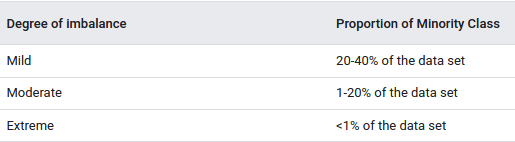]

**Question : Is the likelihood of survival dependent on gender?**

In [17]:
# Passenger count based on the gender 
train_df['Sex'].value_counts().to_frame()

In [18]:
# Survival ratio based on gender
train_df.groupby('Sex').Survived.mean().to_frame()

In [24]:
# Survival rate bar chart based on gender
bar_chart_stack(train_df, "Sex")

Here, we can clearly see that even though the majority of passenger were men, the majority of survivors were women. The key observation here is that the survival rate for female passengers is 4 times higher than the survival rate of male passengers. This seems to confirm that the phrase “women and children first” does indeed seem to have been a rule to which men adhered.

**Question : Could it be that the class to which a passenger belonged correlates with the probability of survival??**

In [26]:
# passenger count W.R.T class
pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'Ticket', aggfunc = 'count')

In [27]:
# Passenger class distribution 
train_df.groupby('Pclass').Survived.mean().to_frame()

In [28]:
# Bar chart passenger class vs dependent (target) variable ,,survived”
bar_chart_stack(train_df, "Pclass")

From the plots and tables above it becomes clear that the Pclass is an important factor to consider.

* Most passenger had class 3 tickets, yet only 24% of class 3 passengers survived.
* Almost 63% of the passenger from class 1 survived.
* Approx 50% of the class 2 passenger survived.

However, it is yet not clear weather the class or the gender is the underlying and deciding factor. Which brings another important question:

**Question: Is the higher survival rate in Class 1 due to the class itself or to a gender distribution in which female passengers dominate?**

In [77]:
# Function that plots bar chart with multiple features
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class'"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')

In [79]:
# Bar chart of gender vs surival rate
bar_chart_compare(train_df, "Pclass", "Sex")

In [36]:
# Percentage of male and female survivors with respect to gender
train_df.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

Here, we can see that the question raised above was justified. Irrespective of the class the most important factor when it comes to surviving was gender. (At least between the two features Sex and Pclass). However, men in class 1 had a significantly higher chance of survival if they bought class 1 tickets. This just shows to say that we should keep both features as both yield insightful information that should help our model.

* Survival Rate females 1. Class: 96,8%
* Survival Rate females 2. Class: 92,1%
* Survival Rate females 3. Class: 50%
* Survival Rate male 1. Class: 36.8%
  (still significantly lower than 3. class females)

**Question: Did a passengers age influence the chance of survival?**

In [41]:
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)

In [39]:
# Utility function for plotting a histogram and the kernel density estimate
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"]==1], shade=True, ax=ax,
                label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"]==0], shade=True, ax=ax,
                label='Died')
    

In [43]:
# Age distribution
plot_distribution(train_df, "Age", "Age Distribution Passengers")

In [44]:
#Age kernel density
plot_kernel_density_estimate_survivors(train_df, "Age", "Age Distribution Survived vs Died")

The Histogram above shows that age follows a fairly normal distribution. Also investigating the kernel density estimate does not provide additional information except from a raise in survivors at a very young age. However, one idea might be to investigate age and sex together using a swarm plot, as it does not seem plausible that age has no influence on the chance of survival:

**Analyze FeatureFeature Age & Sex together**

In [45]:
# Function for creating a swarm plot
def plot_swarm_survivors(dataset, feature1, feature2, title, fize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis.
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived',data=train_df).set_title(title)

In [47]:
plot_swarm_survivors(train_df, "Sex", "Age", "Survivor Swarmplot for Age and Gender")


As expected age holds valuable information. The swarm plot above shows that a big portion of male survivors are passengers between 0 and 12 years of age. It's also interesting to see that the oldest passenger 80 year old man survived.

**Analyze Features Age and Pclass together**

In [48]:
plot_swarm_survivors(train_df, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")

Once more we can see the importance of Pclass when it comes to predicting the likelihood of survival. One additional piece of information from the plot above is that the first-class did not have a lot of children. Maybe rich people get fewer kids?

**Analyze Feature Fare**

In [50]:
train_df.Fare.describe()

In [51]:
plot_distribution(train_df, "Fare", "Fare Distribution Passengers")

In [52]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')

In [53]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']

plot_quartiles(train_df, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

As we can see the likelihood of survival is definitely influenced by the price paid.

* Cheap (0-25% of max Price): Surival Rate = 0.2 (aprox)
* Cheap (25%-50% of max Price): Surival Rate = 0.3 (aprox)
* Cheap (50%-75% of max Price): Surival Rate = 0.45 (aprox)
* Cheap (75%-100% of max Price): Surival Rate = 0.55 (aprox)

Additionally, we can investigate the relationship between fare, sex and survived to further understand the importance of the feature.

In [54]:
plot_swarm_survivors(train_df, "Fare", "Sex","Survivor Swarmplot for Age and Gender")

Here, some important observations can be made:

* Irrespective of gender all passengers with a fare above 500$   survived.
* 
* All male passenger that paid between 200-300 $ died
* 
* All female passenger that paid between 200-300 $ died

This could be a feature a classifier might pick up.

One thing that caught my attention is that the minimum fare paid was 0.0 $.

This seems highly unlikely. We can investigate who these people were:

In [55]:
train_df.loc[train_df.Fare==0]

In [56]:
len(train_df.loc[train_df.Fare==0])

15 Passengers paid no fare. As this is nonsensical I decide to replace 0 values with nan and then later to think about how to impute these values.

In [57]:
# Replace Fare == 0 with nan
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN
test_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN

**Analyze Feature Embarked**

In [58]:
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)

In [60]:
bar_chart_stack(train_df, 'Embarked')

In [61]:
show_countplot(train_df, "Embarked", 'Passengers count by boarding point')

In [62]:
train_df['Embarked'].value_counts().to_frame()

In [63]:
show_compare_countplot(train_df, "Embarked", "Survived", "Survivor count by place of embarktion")

In [64]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

In [65]:
train_df.groupby(['Embarked']).Survived.mean().to_frame()

There are three possible values for the Embarked Feature:

* Southampton, Cherbourg, and Queenstown.

We can see that the majority of passengers embarked from Southampton. However, only 33% survived the sinking of the titanic.

The highest survival rate of 55% is in the group of passengers that embarked from Cherbourg

Using common sense I would not expect that the place of border changes the likelihood of survival.

Why is the likelihood of survival higher at Cherbourg? As we know from above a better class increases the survival rate drastically. One indicator may be the percentage of 1. Class passengers that embarked at Cherbourg:

**Analyze Features Embarked & Pclass together**

In [66]:
show_compare_countplot(train_df, "Embarked", "Pclass", "Passenger count by place of embarktion and class")

In [67]:
train_df.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()

The hypothesis seems to be correct.

* The majority embarked at Cherbourg were 1. class passengers.
* The majority embarked at Southampton were 3. class passengers.

However, it does not explain why the survival rate at Queenstown is slightly higher than at Southampton even though the number of 1. class passenger concerning 3. class passengers is higher at Southampton.

One hypothesis is that maybe the ratio between male and female passengers differs:

**Analyze Features Embarked & Sex together**

In [68]:
show_compare_countplot(train_df, "Embarked", "Sex", "Passenger count by place of embarktion and sex")

As expected twice as many male passengers embarked from Southam were roughly the same number of male and female passengers embarked from Queenstown. This just shows the importance of the Sex feature.

**Analyze Feature SibSp:**

SibSp is the number of siblings or spouses of a person aboard the Titanic

In [69]:
train_df['SibSp'].value_counts().to_frame()

In [80]:
bar_chart_compare(train_df, "SibSp", title = "Surival rate by siblings / spouses aboard the Titanic")

In [81]:
train_df.groupby(['SibSp']).Survived.mean().to_frame()

In [82]:
show_countplot(train_df, "SibSp", 'SibSp Distribution', (15,3))

In [83]:
show_compare_countplot(train_df, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")

The majority traveled alone. It seems that the more Sibling a passenger has the less chance of survival there is.

**Analyze Feature Parch**

Similar to the SibSp column, this feature contains the number of parents or children each passenger was traveling with.

Here we draw the same conclusions as SibSp; we see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

In [84]:
show_countplot(train_df, "Parch", 'Parch Distribution', (15,3))

In [85]:
bar_chart_compare(train_df, "Parch", title = "Survival rate by Parch")

In [86]:
train_df.groupby(['Parch']).Survived.mean().to_frame()

In [87]:
show_compare_countplot(train_df, "Parch", "Survived", "Survivor count by Parch")

Similar to the SibSp column, this feature contains the number of parents or children each passenger was traveling with. Here we draw the same conclusions as SibSp; we see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

Both features do not seem to be very informative, however, higher abstraction levels trees might pick up certain groups. For faster training, it might be beneficial to combine both features into 1 and create a family size feature.

# Feature engineering

**Feature Name**

In [88]:
pd.unique(train_df['Name'])

To create a new feature we can extract the Titles from the name.


In [89]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [90]:
train_df.head()

In [91]:
train_df['Title'].value_counts().to_frame()

In [92]:
show_countplot(train_df, "Title", 'Title Distribution', (15,3))

As can see the Titles are severely imbalanced. In makes sense ti group less frequent Titles together. I will substitute male titles into Mr and female Titles into Mr:

In [93]:
train_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
test_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
train_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
test_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

In [94]:
show_countplot(train_df, "Title", 'Title Distribution after substitution', (15,3))

In [96]:
bar_chart_stack(train_df, 'Title')

In [97]:
bar_chart_compare(train_df, "Title", title = "Survival rate by Title")

* As expected female Titles result in a higher survival rate.
* Master and Dr are slightly have a surprisingly high survival rate even   tough both are male titles
* Being "just" a Mr comes with a compromised survival rate of approx 15%
* It is interesting that all 6 Revernands died. Maybe they decided to accept their destiny and wanted to die with dignity

**Cabin and Ticket**

In [98]:
train_df[['Cabin', 'Ticket']]

As we can see both features are not easy to deal with. Cabin contains a lot of Nans and the ticket seems not to provide any useful information.

We can try different ideas:

* Extract two leading letters to create a new feature
* Extract number of letter in ticket to create a new features
* Extract number of cabins used
* Extract Cabin letter

In [99]:
# Extract Leading Letter:
train_df['Ticket_2letter'] = train_df.Ticket.apply(lambda x: x[:2])
test_df['Ticket_2letter'] = test_df.Ticket.apply(lambda x: x[:2])

In [100]:
# Extract Ticket Lenght:
train_df['Ticket_len'] = train_df.Ticket.apply(lambda x: len(x))
test_df['Ticket_len'] = test_df.Ticket.apply(lambda x: len(x))

In [101]:
# Extract Number of Cabins:
train_df['Cabin_num'] = train_df.Ticket.apply(lambda x: len(x.split()))
test_df['Cabin_num'] = test_df.Ticket.apply(lambda x: len(x.split()))

In [102]:
# Extract Leading Letter:
train_df['Cabin_1letter'] = train_df.Ticket.apply(lambda x: x[:1])
test_df['Cabin_1letter'] = test_df.Ticket.apply(lambda x: x[:1])

**Investigate Results:**

Ticket:

In [103]:
len(train_df['Ticket'].value_counts().to_frame())

In [104]:
len(train_df["Ticket_2letter"].value_counts().to_frame())

In [105]:
len(train_df["Ticket_len"].value_counts().to_frame())

In [106]:
train_df.head()

**Cabin:**

In [107]:
len(train_df['Cabin'].value_counts().to_frame())

In [108]:
len(train_df['Cabin_num'].value_counts().to_frame())

In [109]:
train_df['Cabin_num'].value_counts().to_frame()

In [110]:
len(train_df['Cabin_1letter'].value_counts().to_frame())

**Feature Family Size**

Both features do not seem to be very informative, however, higher abstraction levels trees might pick up certain groups. For faster training, it might be beneficial to combine both features into 1 and create a family size feature.

In [111]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [112]:
bar_chart_compare(train_df, "Fam_size", title = "Survival rate by family size")

In [113]:
show_compare_countplot(train_df, "Fam_size", "Survived", "Survivor count by family size")

**Feature Family Type**

To further summarize the previous trend, as our final feature, Let's create four groups for family size

In [114]:
# Creation of four groups
train_df['Fam_type'] = pd.cut(train_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_df['Fam_type'] = pd.cut(test_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

In [115]:
bar_chart_compare(train_df, "Fam_type", title = "Surival rate by family type")

In [116]:
show_compare_countplot(train_df, "Fam_type", "Survived", "Survivor count by family type")

# **Training a classifier**

* We start by selecting the features we will use and isolating the target.
* We will not consider Cabin and in the end, we also excluded Age as the relevant information which is being a young man is encoded in the Master title.
* We also did not use Sex as it is not useful given the Title column:
adult males and young children have the same sex but are different categories as we saw before, so we don't want to confuse our algorithm.

In [117]:
y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']
X = train_df[features]
X.head()

In [118]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter']

# Inputing numerical values with median
numerical_transformer = SimpleImputer(strategy='median')

# Inputing missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Training
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

In [119]:
X_test = test_df[features]
X_test.head()

In [120]:
predictions = titanic_pipeline.predict(X_test)

In [122]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')